In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
from datetime import datetime, date
import json
from xgrads import open_CtlDataset
import geopandas as gpd
import requests
import hydrofunctions as hf
import matplotlib.pyplot as plt
import folium 
%matplotlib inline

In [4]:
# Choose a domain
domain = 'YUKO'

# calibration dates
# start calibration date    
st_dtcal = '2011-10-01'
# end calibration date
ed_dtcal = '2018-09-30'

# paths 
SMpath = '/nfs/attic/dfh/2020_NPRB/domain_'+domain+'/snowmodel2023_cfsv2/'
# data location
datapath = '/nfs/attic/dfh/2020_NPRB/data/'
# stream gauge data
flowpath = datapath+'stream_gage/'+domain+'/'
# calibration disgharge data
flowdatacal = flowpath+domain+'_discharge_cfs_'+st_dtcal+'_'+ed_dtcal+'.csv'
# calibration station gdf
flowstncal = flowpath+domain+'_gage_meta_'+st_dtcal+'_'+ed_dtcal+'.geojson'
# calibration station gdf projected
flowstnprojcal = flowpath+domain+'_gage_meta_proj_'+st_dtcal+'_'+ed_dtcal+'.geojson'

#path to NPRB domains
domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
domains = domains_resp.json()

In [5]:
stnproj = gpd.read_file(flowstnprojcal)

This notebook requires manual examination of each station to retrieve the i, j pair from the hydroflow data. Manual corrections are often required to match the station location to the stream channel that was determined in hydroflow. 

# find i j pair for each station 

Need to find the i j pair for each of the gage locations to extract hydroflow output. To do this - each station locaiton needs to be compared to the disgarge output to make sure it align with the computed river network. 

In [6]:
#use topo to get spatial info
# SM forcing files 
SMdatapath = datapath+'SMinputs/'+domain+'/'
# dem ascii file
demasc = SMdatapath+domain+'_dem.asc'

topo = rxr.open_rasterio(demasc)

In [7]:
#hydroflow discharge data using pixel centers 
ctlFile = SMpath+'outputs/wo_assim/disc_base.ctl'

q = open_CtlDataset(ctlFile)
q=q.assign_coords({"lat": np.flipud(topo.y.values)-int(domains[domain]['cellsize']),"lon": topo.x.values-int(domains[domain]['cellsize'])})

q

,Array,Chunk
Bytes,4.33 GiB,1.73 MiB
Shape,"(2557, 1, 527, 863)","(1, 1, 527, 863)"
Count,2557 Tasks,2557 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,4.33 GiB,1.73 MiB
Shape,"(2557, 1, 527, 863)","(1, 1, 527, 863)"
Count,2557 Tasks,2557 Chunks
Type,float32,numpy.ndarray


In [8]:
# domain shapefile
shp = gpd.read_file('/nfs/attic/dfh/2020_NPRB/data/gis/'+domain+'/'+domain+'.json')
shpproj = shp.to_crs(stnproj.crs)

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

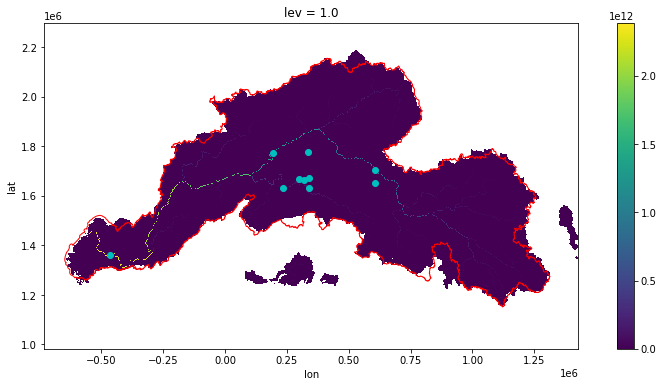

In [9]:
qsum = q.slow.isel(lev=0).sum('time')+q.fast.isel(lev=0).sum('time')

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
shpproj.plot(ax=ax,facecolor='None',edgecolor='r')

In [10]:
# Add custom base maps to folium
basemaps = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True
    ),
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    ),
    'Google Satellite Hybrid': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Esri Satellite': folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
    )
}

In [11]:
stnproj

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no,geometry
0,USGS,15348000,FORTYMILE R NR STEELE CREEK AK,ST,641833.0,1412408.0,64.308855,-141.404517,M,S,...,None,NYNNNNNN,None,None,None,None,None,None,None,POINT (605177.726 1651517.276)
1,USGS,15356000,YUKON R AT EAGLE AK,ST,644722.0,1411152.0,64.789168,-141.200089,M,T,...,None,NNNNNNNN,None,None,None,None,None,None,None,POINT (604614.263 1705991.348)
2,USGS,15452100,BEAVER C AB VICTORIA C NR BEAVER AK,ST,654820.0,1463855.0,65.805163,-146.651134,M,S,...,None,Y,None,None,None,None,None,None,None,POINT (336073.332 1779372.743)
3,USGS,15453500,YUKON R NR STEVENS VILLAGE AK,ST,655232.0,1494304.0,65.875101,-149.720349,M,T,...,None,NNNNNNNN,None,None,None,None,None,None,None,POINT (195477.028 1774845.188)
4,USGS,15484000,SALCHA R NR SALCHAKET AK,ST,642817.5,1465541.0,64.471528,-146.928056,Y,1,...,None,NYNNNNNN,None,None,None,None,None,None,None,POINT (339257.642 1630189.739)
5,USGS,15493400,CHENA R BL HUNTS C NR TWO RIVERS AK,ST,645136.0,1464812.0,64.859588,-146.805750,R,U,...,None,NNNNNNNN,None,None,None,None,None,None,None,POINT (340421.886 1673854.717)
6,USGS,15493700,CHENA R BL MOOSE C DAM AK,ST,644803.0,1471340.0,64.800412,-147.230193,N,S,...,None,NNNNNNNN,None,None,None,None,None,None,None,POINT (321081.246 1665177.732)
7,USGS,15514000,CHENA R AT FAIRBANKS AK,ST,645045.0,1474204.0,64.845403,-147.703536,M,T,...,None,NYNNNNNN,None,None,None,None,None,None,None,POINT (298226.175 1667964.014)
8,USGS,15515500,TANANA R AT NENANA AK,ST,643353.8,1490538.4,64.564944,-149.094000,Y,1,...,None,NYNNNNNN,None,None,None,None,None,None,None,POINT (234813.943 1631209.495)
9,USGS,15565447,YUKON R AT PILOT STATION AK,ST,615604.0,1625250.0,61.933687,-162.882936,M,S,...,None,NYNNNNNN,None,None,None,None,None,None,None,POINT (-463483.512 1359601.750)


In [12]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

# 15348000

In [14]:
i=0
stnproj.site_no[i]

'15348000'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

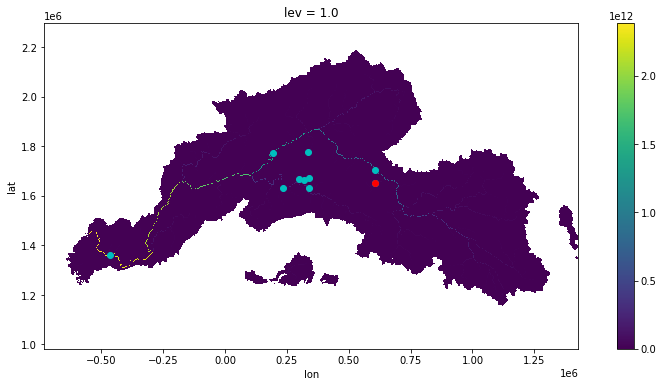

In [15]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15348000


(596250.0, 616250.0)

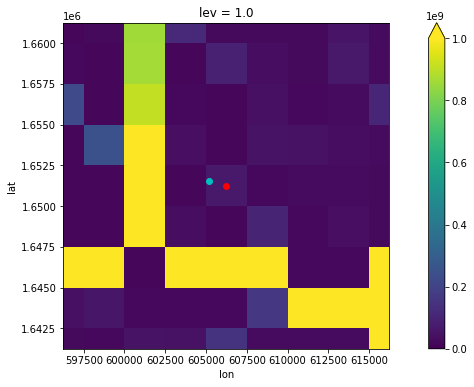

In [18]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e9,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-10000,dftest.y.values[0]+10000])
plt.xlim([dftest.x.values[0]-10000,dftest.x.values[0]+10000])

In [19]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)


yidx =  267
xidx =  534


(596250.0, 616250.0)

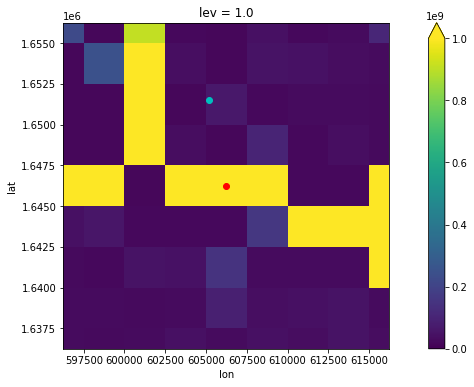

In [21]:
yidx = int(np.where(q.lat == slow.lat)[0]-2)
xidx = int(np.where(q.lon == slow.lon)[0])
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e9,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-10000,dftest.y.values[0]+10000])
plt.xlim([dftest.x.values[0]-10000,dftest.x.values[0]+10000])

In [22]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  265
xidx fixed =  534


In [23]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [24]:
#indicies to save out
xidx1 = xidx
yidx1 = yidx

# 15356000

In [129]:
i=1
stnproj.site_no[i]

'15356000'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

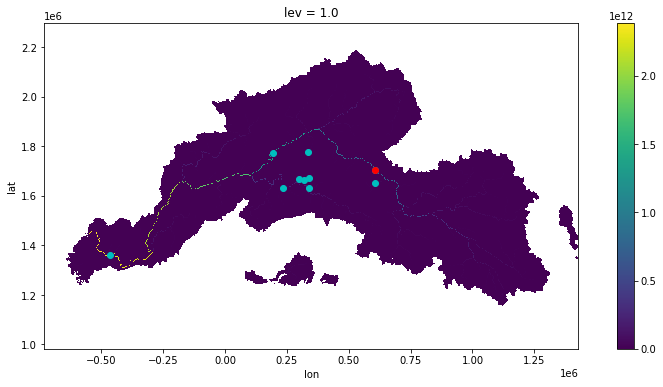

In [130]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15356000


(583750.0, 623750.0)

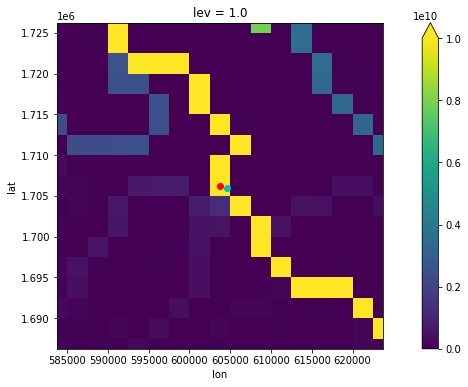

In [131]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e10,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-20000,dftest.y.values[0]+20000])
plt.xlim([dftest.x.values[0]-20000,dftest.x.values[0]+20000])

In [132]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)


yidx =  289
xidx =  533


In [29]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [133]:
#indicies to save out
xidx2 = xidx
yidx2 = yidx

# 15452100

In [32]:
i=2
stnproj.site_no[i]

'15452100'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

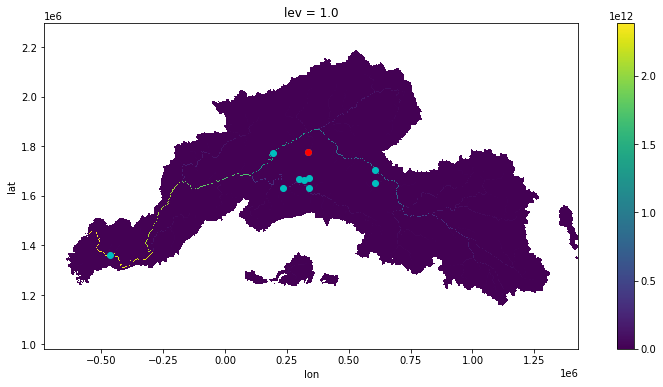

In [33]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15452100


(324250.0, 348250.0)

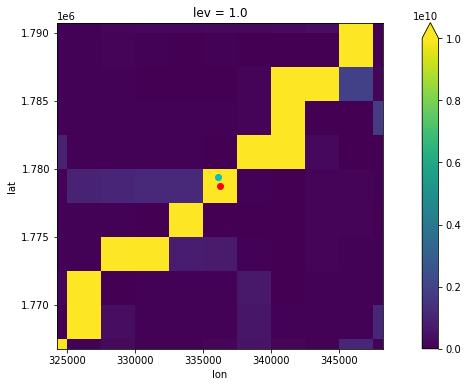

In [34]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e10,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-12000,dftest.y.values[0]+12000])
plt.xlim([dftest.x.values[0]-12000,dftest.x.values[0]+12000])

In [35]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  318
xidx =  426


In [36]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [37]:
#indicies to save out
xidx3 = xidx
yidx3 = yidx

# 15453500

In [39]:
i=3
stnproj.site_no[i]

'15453500'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

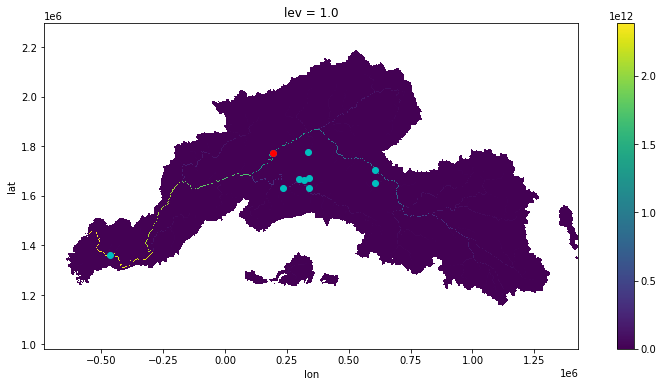

In [40]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15453500


(184250.0, 208250.0)

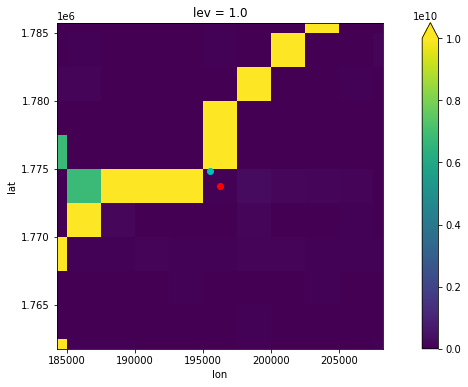

In [45]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e10,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-12000,dftest.y.values[0]+12000])
plt.xlim([dftest.x.values[0]-12000,dftest.x.values[0]+12000])

In [46]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  316
xidx =  370


(181750.0, 205750.0)

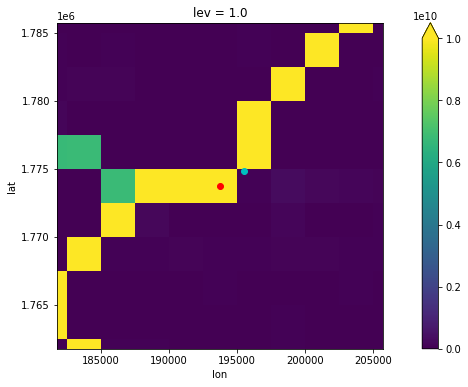

In [47]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0]-1)
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e10,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-12000,dftest.y.values[0]+12000])
plt.xlim([dftest.x.values[0]-12000,dftest.x.values[0]+12000])

In [48]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  316
xidx fixed =  369


In [49]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [50]:
#indicies to save out
xidx4 = xidx
yidx4 = yidx

# 15484000

In [105]:
i=4
stnproj.site_no[i]

'15484000'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

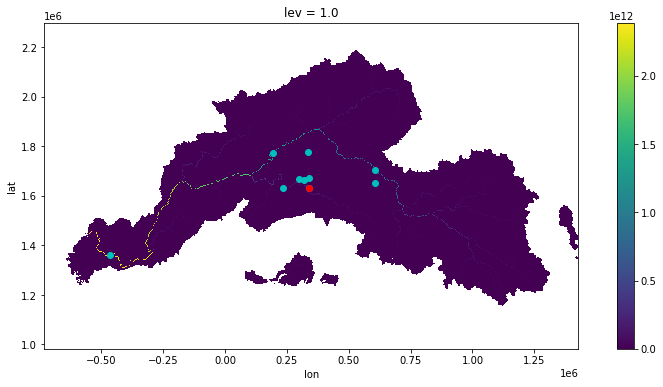

In [106]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15484000


(326750.0, 350750.0)

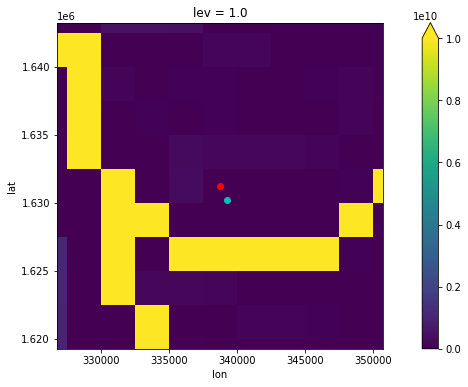

In [107]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e10,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-12000,dftest.y.values[0]+12000])
plt.xlim([dftest.x.values[0]-12000,dftest.x.values[0]+12000])

In [108]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  259
xidx =  427


(326750.0, 350750.0)

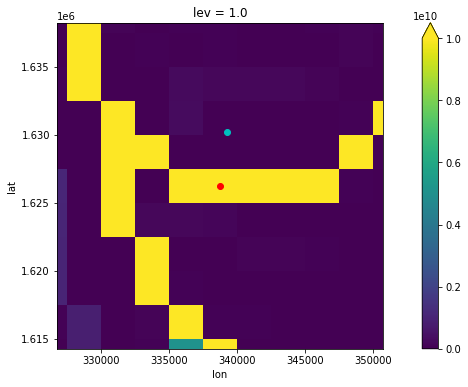

In [109]:
yidx = int(np.where(q.lat == slow.lat)[0]-2)
xidx = int(np.where(q.lon == slow.lon)[0])
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e10,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-12000,dftest.y.values[0]+12000])
plt.xlim([dftest.x.values[0]-12000,dftest.x.values[0]+12000])

In [110]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  257
xidx fixed =  427


In [111]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [112]:
#indicies to save out
xidx5 = xidx
yidx5 = yidx

# 15493400

In [61]:
i=5
stnproj.site_no[i]

'15493400'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

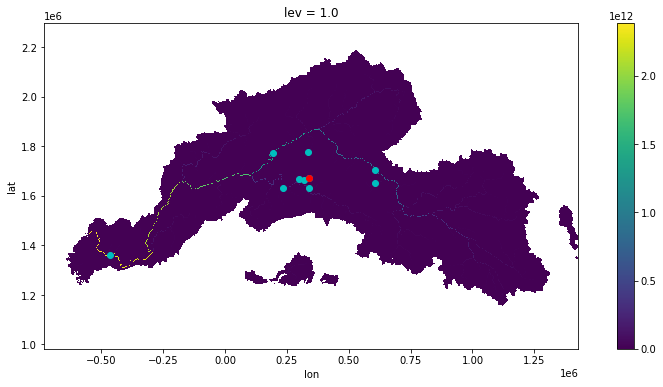

In [62]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15493400


(329250.0, 353250.0)

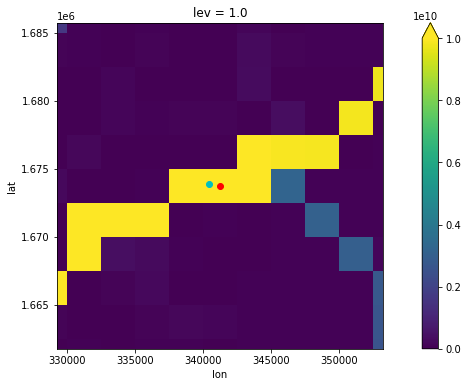

In [63]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e10,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-12000,dftest.y.values[0]+12000])
plt.xlim([dftest.x.values[0]-12000,dftest.x.values[0]+12000])

In [64]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  276
xidx =  428


In [65]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [66]:
#indicies to save out
xidx6 = xidx
yidx6 = yidx

# 15493700

In [68]:
i=6
stnproj.site_no[i]

'15493700'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

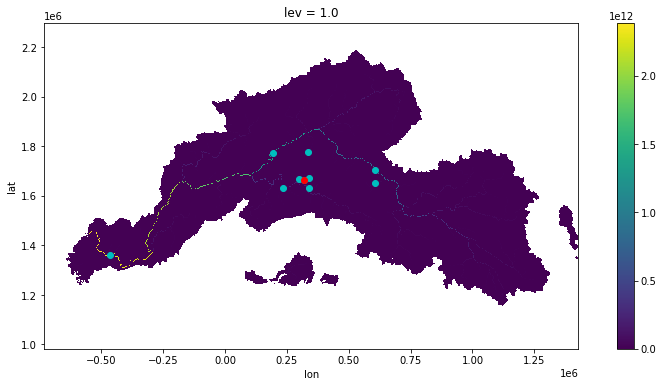

In [69]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15493700


(309250.0, 333250.0)

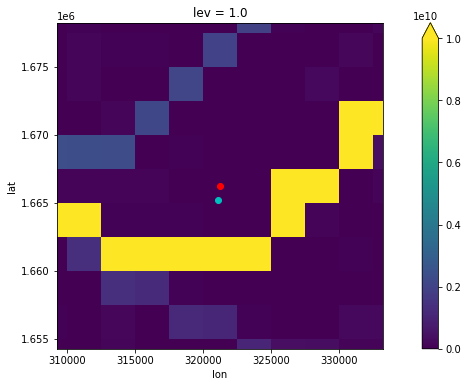

In [70]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e10,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-12000,dftest.y.values[0]+12000])
plt.xlim([dftest.x.values[0]-12000,dftest.x.values[0]+12000])

In [71]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  273
xidx =  420


(309250.0, 333250.0)

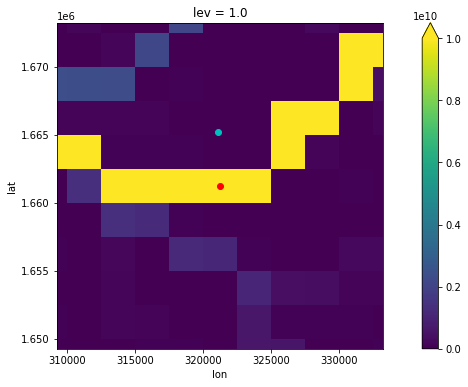

In [72]:
yidx = int(np.where(q.lat == slow.lat)[0]-2)
xidx = int(np.where(q.lon == slow.lon)[0])
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e10,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-12000,dftest.y.values[0]+12000])
plt.xlim([dftest.x.values[0]-12000,dftest.x.values[0]+12000])

In [73]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  271
xidx fixed =  420


In [74]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [75]:
#indicies to save out
xidx7 = xidx
yidx7 = yidx

# 15514000

In [77]:
i=7
stnproj.site_no[i]

'15514000'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

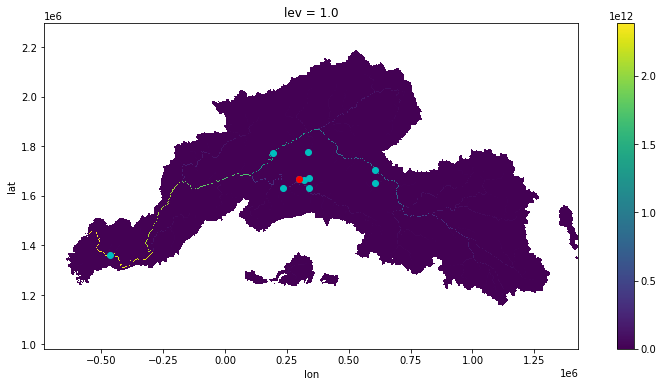

In [78]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15514000


(286750.0, 310750.0)

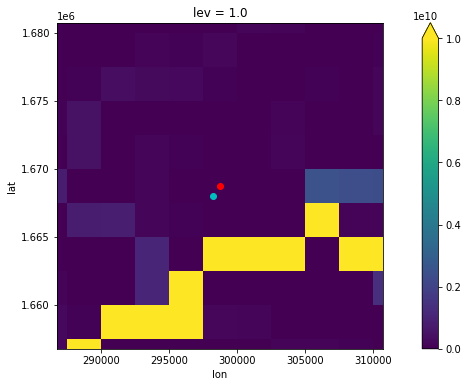

In [79]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e10,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-12000,dftest.y.values[0]+12000])
plt.xlim([dftest.x.values[0]-12000,dftest.x.values[0]+12000])

In [80]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  274
xidx =  411


Note: need to move the lat down by one pixel to reside in the modeled channel 

(286750.0, 310750.0)

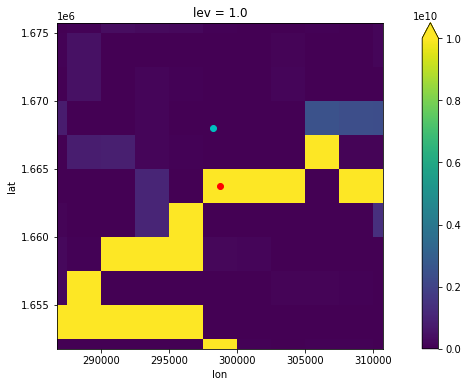

In [81]:
yidx = int(np.where(q.lat == slow.lat)[0]-2)
xidx = int(np.where(q.lon == slow.lon)[0])
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e10,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-12000,dftest.y.values[0]+12000])
plt.xlim([dftest.x.values[0]-12000,dftest.x.values[0]+12000])

In [82]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  272
xidx fixed =  411


In [83]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [84]:
#indicies to save out
xidx8 = xidx
yidx8 = yidx

# 15515500

In [86]:
i=8
stnproj.site_no[i]

'15515500'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

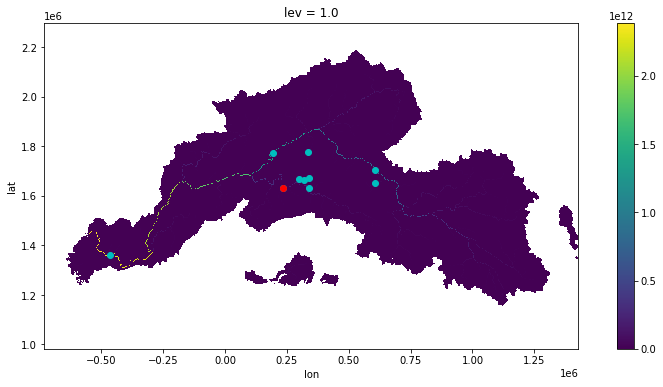

In [87]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15515500


(221750.0, 245750.0)

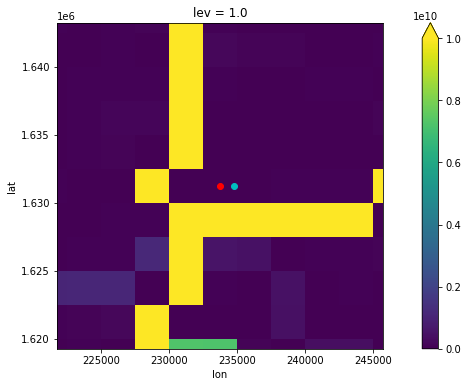

In [88]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e10,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-12000,dftest.y.values[0]+12000])
plt.xlim([dftest.x.values[0]-12000,dftest.x.values[0]+12000])

In [89]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  259
xidx =  385


Note: need to move the lon to the left by 1 pixel to reside in the modeled channel 

(219250.0, 243250.0)

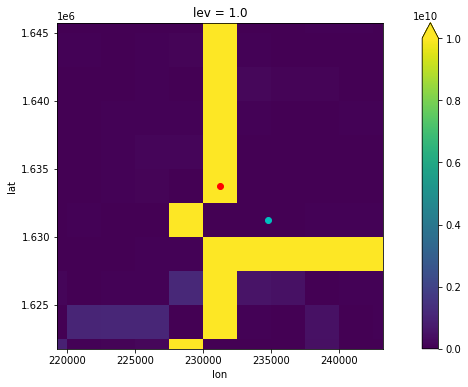

In [91]:
yidx = int(np.where(q.lat == slow.lat)[0]+1)
xidx = int(np.where(q.lon == slow.lon)[0]-1)
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e10,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-12000,dftest.y.values[0]+12000])
plt.xlim([dftest.x.values[0]-12000,dftest.x.values[0]+12000])

In [92]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  260
xidx fixed =  384


In [90]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [93]:
#indicies to save out
xidx9 = xidx
yidx9 = yidx

# 15565447

In [134]:
i=9
stnproj.site_no[i]

'15565447'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

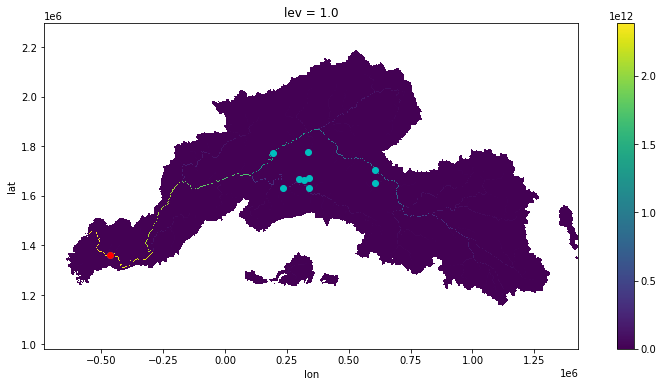

In [135]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15565447


(-513750.0, -413750.0)

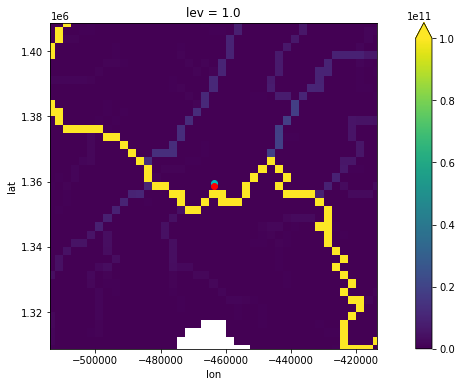

In [136]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e11,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-50000,dftest.y.values[0]+50000])
plt.xlim([dftest.x.values[0]-50000,dftest.x.values[0]+50000])

In [137]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  150
xidx =  106


Note: need to move the lon to the left by two pixel to land in the modeled channel 

(-475750.0, -451750.0)

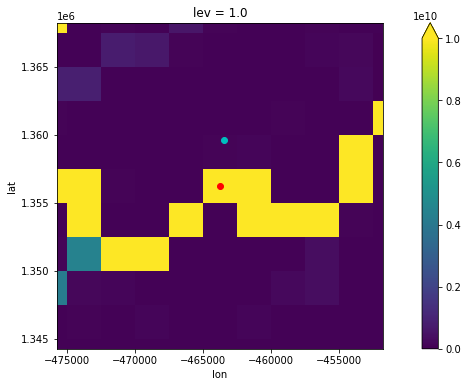

In [125]:
yidx = int(np.where(q.lat == slow.lat)[0]-1)
xidx = int(np.where(q.lon == slow.lon)[0])
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e10,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-12000,dftest.y.values[0]+12000])
plt.xlim([dftest.x.values[0]-12000,dftest.x.values[0]+12000])

In [126]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  149
xidx fixed =  106


In [102]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [103]:
#indicies to save out
xidx10 = xidx
yidx10 = yidx

## save data

In [138]:
# from anaylsis above
xidx = [xidx1,xidx2,xidx3,xidx4,xidx5,xidx6,xidx7,xidx8,xidx9,xidx10]
yidx = [yidx1,yidx2,yidx3,yidx4,yidx5,yidx6,yidx7,yidx8,yidx9,yidx10]

In [139]:
# add x and y idx to metadata
stnproj['xidx'] = xidx
stnproj['yidx'] = yidx
path=flowstnprojcal
stnproj.to_file(path, driver='GeoJSON') 

/nfs/attic/dfh/miniconda/envs/nprb/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [140]:
stnproj

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no,geometry,xidx,yidx
0,USGS,15348000,FORTYMILE R NR STEELE CREEK AK,ST,641833.0,1412408.0,64.308855,-141.404517,M,S,...,None,None,None,None,None,None,None,POINT (605177.726 1651517.276),534,265
1,USGS,15356000,YUKON R AT EAGLE AK,ST,644722.0,1411152.0,64.789168,-141.200089,M,T,...,None,None,None,None,None,None,None,POINT (604614.263 1705991.348),533,289
2,USGS,15452100,BEAVER C AB VICTORIA C NR BEAVER AK,ST,654820.0,1463855.0,65.805163,-146.651134,M,S,...,None,None,None,None,None,None,None,POINT (336073.332 1779372.743),426,318
3,USGS,15453500,YUKON R NR STEVENS VILLAGE AK,ST,655232.0,1494304.0,65.875101,-149.720349,M,T,...,None,None,None,None,None,None,None,POINT (195477.028 1774845.188),369,316
4,USGS,15484000,SALCHA R NR SALCHAKET AK,ST,642817.5,1465541.0,64.471528,-146.928056,Y,1,...,None,None,None,None,None,None,None,POINT (339257.642 1630189.739),427,257
5,USGS,15493400,CHENA R BL HUNTS C NR TWO RIVERS AK,ST,645136.0,1464812.0,64.859588,-146.805750,R,U,...,None,None,None,None,None,None,None,POINT (340421.886 1673854.717),428,276
6,USGS,15493700,CHENA R BL MOOSE C DAM AK,ST,644803.0,1471340.0,64.800412,-147.230193,N,S,...,None,None,None,None,None,None,None,POINT (321081.246 1665177.732),420,271
7,USGS,15514000,CHENA R AT FAIRBANKS AK,ST,645045.0,1474204.0,64.845403,-147.703536,M,T,...,None,None,None,None,None,None,None,POINT (298226.175 1667964.014),411,272
8,USGS,15515500,TANANA R AT NENANA AK,ST,643353.8,1490538.4,64.564944,-149.094000,Y,1,...,None,None,None,None,None,None,None,POINT (234813.943 1631209.495),384,260
9,USGS,15565447,YUKON R AT PILOT STATION AK,ST,615604.0,1625250.0,61.933687,-162.882936,M,S,...,None,None,None,None,None,None,None,POINT (-463483.512 1359601.750),106,149
